# Assignment 5: Using time series data to forecast emergency department arrivals

In [1]:
%matplotlib inline
import matplotlib.pylab
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rc("figure", figsize=(12,10))
import pandas as pd
import numpy as np
import datetime
import math

## Importing and wrangling the time series data

In [3]:
ts = pd.read_csv('patient_ts.csv', index_col=0)
ts.head()

,0
2014-01-01 00:00:00,2.0
2014-01-01 01:00:00,2.0
2014-01-01 02:00:00,3.0
2014-01-01 03:00:00,1.0
2014-01-01 04:00:00,1.0


#### Check the index type

In [4]:
type(ts.index)

pandas.core.indexes.base.Index

#### Change the index to a datetime index

In [5]:
ts.index = pd.to_datetime(ts.index, format= '%Y-%m-%d %H:%M:%S')
ts.head()

,0
2014-01-01 00:00:00,2.0
2014-01-01 01:00:00,2.0
2014-01-01 02:00:00,3.0
2014-01-01 03:00:00,1.0
2014-01-01 04:00:00,1.0


In [6]:
type(ts.index)

pandas.core.indexes.datetimes.DatetimeIndex

#### Set the time series frequency to 'Hourly'

In [7]:
ts = ts.asfreq('H')

#### Change the column name to 'patients'

In [8]:
ts.columns = ['patients']
ts.head()

,patients
2014-01-01 00:00:00,2.0
2014-01-01 01:00:00,2.0
2014-01-01 02:00:00,3.0
2014-01-01 03:00:00,1.0
2014-01-01 04:00:00,1.0


#### Convert to a pandas series

In [9]:
ts = ts['patients']
type(ts)

pandas.core.series.Series

In [10]:
ts.head()

2014-01-01 00:00:00    2.0
2014-01-01 01:00:00    2.0
2014-01-01 02:00:00    3.0
2014-01-01 03:00:00    1.0
2014-01-01 04:00:00    1.0
Freq: H, Name: patients, dtype: float64

## Decomposing the time series

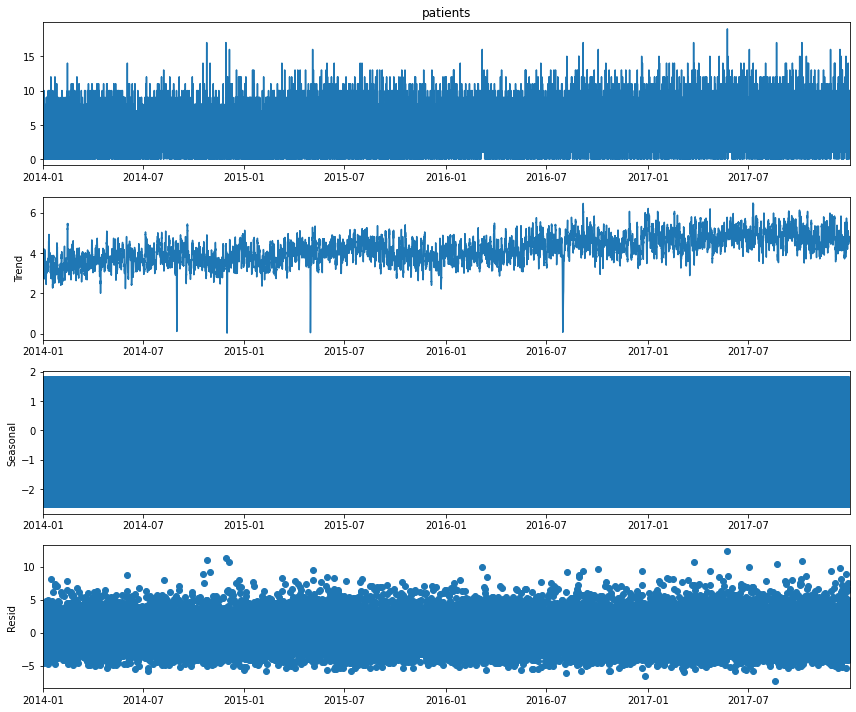

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(ts, model='additive')
result.plot()
pyplot.show()

#### Formatting the data frame for forecasting

In [12]:
patients_df = ts.reset_index()
patients_df.columns = ["timestamp", "patients"]
patients_df.head()

,timestamp,patients
0,2014-01-01 00:00:00,2.0
1,2014-01-01 01:00:00,2.0
2,2014-01-01 02:00:00,3.0
3,2014-01-01 03:00:00,1.0
4,2014-01-01 04:00:00,1.0


The components of our time series are in a Pandas Series, so to append them to the dataframe we have to use the map() function, and the column 'timestamp' as the key.

In [13]:
patients_df["trend"] = patients_df['timestamp'].map(result.trend)
patients_df.head(20)

,timestamp,patients,trend
0,2014-01-01 00:00:00,2.0,NaN
1,2014-01-01 01:00:00,2.0,NaN
2,2014-01-01 02:00:00,3.0,NaN
3,2014-01-01 03:00:00,1.0,NaN
4,2014-01-01 04:00:00,1.0,NaN
5,2014-01-01 05:00:00,2.0,NaN
6,2014-01-01 06:00:00,2.0,NaN
7,2014-01-01 07:00:00,5.0,NaN
8,2014-01-01 08:00:00,5.0,NaN
9,2014-01-01 09:00:00,6.0,NaN


Are the NaNs an error? Nope. remember that when we calculate a trend using a two-sided moving average, we lose some values at the beginning and at the end.

## Adding a column for the seasonal component

What is the proper seasonality time scale for this dataset? In our EDA notebook, we saw that the strongest seasonal signal is observed at the **hourly** time scale. Therefore, we should look at seasonality at this time scale.

In [14]:
patients_df['hour'] = pd.DatetimeIndex(patients_df['timestamp']).hour

In [15]:
patients_df.head()

,timestamp,patients,trend,hour
0,2014-01-01 00:00:00,2.0,NaN,0
1,2014-01-01 01:00:00,2.0,NaN,1
2,2014-01-01 02:00:00,3.0,NaN,2
3,2014-01-01 03:00:00,1.0,NaN,3
4,2014-01-01 04:00:00,1.0,NaN,4


Let's check the data types

In [16]:
patients_df.dtypes

timestamp    datetime64[ns]
patients            float64
trend               float64
hour                  int64
dtype: object

The 'hour' column is an object, but we need it to be treated as a category.

In [17]:
patients_df['hour'] = patients_df.hour.astype("category")

In [18]:
patients_df.dtypes

timestamp    datetime64[ns]
patients            float64
trend               float64
hour               category
dtype: object

We can see that now it's being treated as a category.

### Split into train and test sets

The training set is going to start at row 12 because we have NaNs for the trend before that. The training set is going to be 70% of the time series.

In [19]:
patients_train = patients_df.iloc[12:24540,:]
patients_train.head()

,timestamp,patients,trend,hour
12,2014-01-01 12:00:00,9.0,3.729167,12
13,2014-01-01 13:00:00,3.0,3.708333,13
14,2014-01-01 14:00:00,8.0,3.687500,14
15,2014-01-01 15:00:00,6.0,3.666667,15
16,2014-01-01 16:00:00,6.0,3.666667,16


In [20]:
patients_test = patients_df.iloc[24540:35052,:]
patients_test.tail()

,timestamp,patients,trend,hour
35047,2017-12-31 07:00:00,3.0,4.75,7
35048,2017-12-31 08:00:00,6.0,4.75,8
35049,2017-12-31 09:00:00,8.0,4.75,9
35050,2017-12-31 10:00:00,6.0,4.75,10
35051,2017-12-31 11:00:00,9.0,4.75,11


### Forecasting with the time series trend only

We will be using OLS

In [74]:
from statsmodels.formula.api import ols

from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families.family import Poisson
from statsmodels.genmod.families import links

In [75]:
#linmodel = ols('patients ~ trend', data = patients_train).fit()
#p = linmodel.params
#linmodel.summary()

pmodel = GLM(patients_train.patients, patients_train.trend, family = Poisson(links.log()) )
pres = pmodel.fit(method="newton")
pres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               patients   No. Observations:                24528
Model:                            GLM   Df Residuals:                    24527
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                        newton   Log-Likelihood:                -57590.
Date:                Tue, 06 Jul 2021   Deviance:                       43155.
Time:                        20:27:05   Pearson chi2:                 3.96e+04
No. Iterations:                     2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
trend          0.3413      0.001    433.723      0.000       0.340       0.343
==============================================================================
"""

Next, we'll use the model we've created to predict the number of patients in the test set and in the training set. Then, we'll plot them with the original values to compare the model's performance.

In [76]:
#linpred = linmodel.predict(patients_test)

poisson_predictions = pres.get_prediction(patients_test.trend)
psf_test = poisson_predictions.summary_frame()
psf_test.head(10)

,mean,mean_se,mean_ci_lower,mean_ci_upper
24540,4.778965,0.017235,4.745303,4.812865
24541,4.711488,0.016838,4.678602,4.744605
24542,4.644964,0.016447,4.612839,4.677312
24543,4.579379,0.016065,4.548000,4.610974
24544,4.612054,0.016255,4.580304,4.644025
24545,4.678107,0.016642,4.645604,4.710838
24546,4.514720,0.015690,4.484072,4.545577
24547,4.419439,0.015142,4.389861,4.449216
24548,4.450974,0.015323,4.421043,4.481107
24549,4.388128,0.014963,4.358899,4.417552


In [77]:
#linfit = linmodel.predict(patients_train)

poisson_fit = pres.get_prediction(patients_train.trend)
psf_fit = poisson_fit.summary_frame()
psf_fit.head(10)

,mean,mean_se,mean_ci_lower,mean_ci_upper
12,3.570514,0.010477,3.550038,3.591108
13,3.545217,0.010345,3.524999,3.565551
14,3.520100,0.010214,3.500138,3.540175
15,3.495160,0.010084,3.475451,3.514981
16,3.495160,0.010084,3.475451,3.514981
17,3.445810,0.009829,3.426599,3.465128
18,3.421397,0.009703,3.402432,3.440467
19,3.445810,0.009829,3.426599,3.465128
20,3.373088,0.009456,3.354606,3.391671
21,3.325461,0.009213,3.307453,3.343568


[]

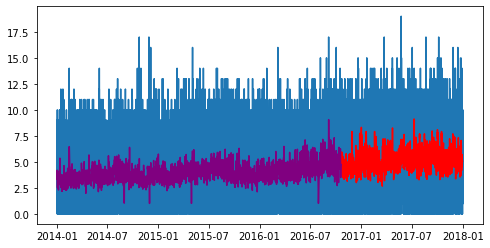

In [78]:
#fig, ax = plt.subplots(figsize=(8,4))
#ax.plot(patients_df['timestamp'], patients_df['patients'])
#ax.plot(patients_test['timestamp'], linpred, 'r')
#ax.plot(patients_train['timestamp'], linfit, 'purple')
#ax.plot()

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(patients_df['timestamp'], patients_df['patients'])
ax.plot(patients_test['timestamp'], psf_test["mean"], 'r')
ax.plot(patients_train['timestamp'], psf_fit["mean"], 'purple')
ax.plot()

#### Let's zoom in a bit to the datetime when the training set ends and the test set begins

[]

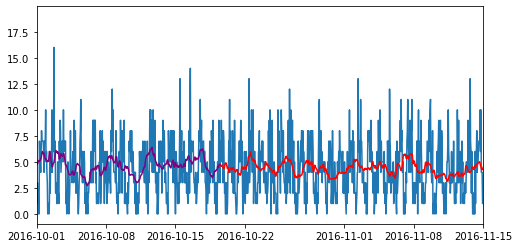

In [79]:
#fig, ax = plt.subplots(figsize=(8,4))
#ax.plot(patients_df['timestamp'], patients_df['patients'])
#ax.plot(patients_test['timestamp'], linpred, 'r')
#ax.plot(patients_train['timestamp'], linfit, 'purple')
#ax.set_xlim([datetime.date(2016, 10, 1), datetime.date(2016, 11, 15)])
#ax.plot()

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(patients_df['timestamp'], patients_df['patients'])
ax.plot(patients_test['timestamp'], psf_test["mean"], 'r')
ax.plot(patients_train['timestamp'], psf_fit["mean"], 'purple')
ax.set_xlim([datetime.date(2016, 10, 1), datetime.date(2016, 11, 15)])
ax.plot()

### Measuring the error in our predictions

In [80]:
from sklearn.metrics import mean_squared_error

Examining the Mean Squared Error for the training set

In [81]:
y_true = patients_df.iloc[12:24540,1] # This is the 'patients' column for the training set
y_pred = psf_fit["mean"]
trend_only_mse_training = mean_squared_error(y_true, y_pred)
trend_only_mse_training

6.338465369127855

Examining the Root Mean Squared Error for the training set

In [82]:
trend_only_rmse_training = math.sqrt(mean_squared_error(y_true, y_pred))
trend_only_rmse_training

2.5176309040699065

Let's check the residuals, too

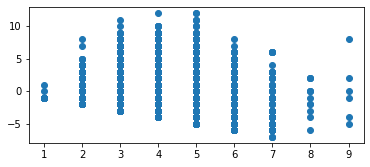

In [83]:
#residual = y_true - y_pred
#fig, ax = plt.subplots(figsize=(6,2.5))
#_ = ax.scatter(y_pred, residual)

residual = y_true - round(y_pred)
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(round(y_pred), residual)

These residuals suggest that our model tends to under-predict the number of patients per hour.

MSE for the test set

In [84]:
y_true = patients_df.iloc[24540:35052,1]
y_pred = psf_test["mean"]
trend_only_mse_test = mean_squared_error(y_true, y_pred)
trend_only_mse_test

8.382552645444864

RMSE for the test set

In [85]:
trend_only_rmse_test = math.sqrt(mean_squared_error(y_true, y_pred))
trend_only_rmse_test

2.895263830023935

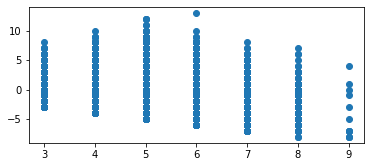

In [86]:
residual = y_true - round(y_pred)
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(round(y_pred), residual)

### OLS with trend and seasonal component

Next, we'll try the same process again, but instead of just having trend as a variable, we'll add the seasonal component (in hours). The capital C in front of hour indicates that it should be used as a categorical variable.

In [95]:
from patsy import dmatrices

In [96]:
#linmodel = ols('patients ~ trend + C(hour)', data = patients_train).fit()
#linmodel.summary()
formula = "patients ~ trend + C(hour)"
response, predictors = dmatrices(formula, patients_train, return_type="dataframe")
pres2 = GLM(response, predictors, family=Poisson(links.log())).fit(method="newton")
pres2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               patients   No. Observations:                24528
Model:                            GLM   Df Residuals:                    24503
Model Family:                 Poisson   Df Model:                           24
Link Function:                    log   Scale:                          1.0000
Method:                        newton   Log-Likelihood:                -49036.
Date:                Tue, 06 Jul 2021   Deviance:                       26046.
Time:                        20:38:46   Pearson chi2:                 2.40e+04
No. Iterations:                     2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.1463      0.030     -4.942      0.000      -0.204      -0.088
C(hour)[T.1]     -0.2187      0.029     -7.415      0.000      -0.276      -0.161
C(hour)[T.2]     -0.3602      0.031    -11.731      0.000      -0.420      -0.300
C(hour)[T.3]     -0.4638      0.032    -14.640      0.000      -0.526      -0.402
C(hour)[T.4]     -0.5368      0.032    -16.564      0.000      -0.600      -0.473
C(hour)[T.5]     -0.5591      0.033    -17.132      0.000      -0.623      -0.495
C(hour)[T.6]     -0.3094      0.030    -10.229      0.000      -0.369      -0.250
C(hour)[T.7]     -0.0104      0.028     -0.371      0.711      -0.065       0.044
C(hour)[T.8]      0.3939      0.025     15.468      0.000       0.344       0.444
C(hour)[T.9]      0.6292      0.024     25.823      0.000       0.581       0.677
C(hour)[T.10]     0.6970      0.024     28.934      0.000       0.650       0.744
C(hour)[T.11]     0.7404      0.024     30.954      0.000       0.693       0.787
C(hour)[T.12]     0.7713      0.024     32.405      0.000       0.725       0.818
C(hour)[T.13]     0.7382      0.024     30.851      0.000       0.691       0.785
C(hour)[T.14]     0.7396      0.024     30.916      0.000       0.693       0.786
C(hour)[T.15]     0.7453      0.024     31.182      0.000       0.698       0.792
C(hour)[T.16]     0.7640      0.024     32.059      0.000       0.717       0.811
C(hour)[T.17]     0.7986      0.024     33.697      0.000       0.752       0.845
C(hour)[T.18]     0.7659      0.024     32.149      0.000       0.719       0.813
C(hour)[T.19]     0.7472      0.024     31.269      0.000       0.700       0.794
C(hour)[T.20]     0.7226      0.024     30.118      0.000       0.676       0.770
C(hour)[T.21]     0.6415      0.024     26.378      0.000       0.594       0.689
C(hour)[T.22]     0.4790      0.025     19.124      0.000       0.430       0.528
C(hour)[T.23]     0.2535      0.026      9.662      0.000       0.202       0.305
trend             0.2691      0.005     49.075      0.000       0.258       0.280
=================================================================================
"""

In [98]:
#linpred = linmodel.predict(patients_test)

response2, predictors2 = dmatrices(formula, patients_test, return_type="dataframe")
poisson_predictions2 = pres2.get_prediction(predictors2)
psf_test2 = poisson_predictions2.summary_frame()
psf_test2.head(10)

,mean,mean_se,mean_ci_lower,mean_ci_upper
24540,6.413966,0.087942,6.243898,6.588665
24541,6.135908,0.085178,5.971214,6.305145
24542,6.076044,0.084033,5.913554,6.242997
24543,6.042570,0.083110,5.881853,6.207678
24544,6.191312,0.084521,6.027851,6.359206
24545,6.481978,0.087307,6.313099,6.655375
24546,6.099770,0.082854,5.939522,6.264341
24547,5.886841,0.080424,5.731305,6.046599
24548,5.776018,0.079978,5.621373,5.934918
24549,5.266979,0.075744,5.120596,5.417546


In [100]:
#linfit = linmodel.predict(patients_train)

poisson_fit2 = pres2.get_prediction(predictors)
psf_fit2 = poisson_fit2.summary_frame()
psf_fit2.head(10)

,mean,mean_se,mean_ci_lower,mean_ci_upper
12,5.096708,0.068734,4.963757,5.233221
13,4.903171,0.067282,4.773058,5.036831
14,4.882633,0.067031,4.753007,5.015795
15,4.883037,0.066930,4.753602,5.015996
16,4.975262,0.067574,4.844567,5.109482
17,5.093316,0.068200,4.961385,5.228756
18,4.901700,0.066783,4.772540,5.034355
19,4.837888,0.066422,4.709438,4.969840
20,4.641537,0.064769,4.516312,4.770234
21,4.232479,0.061602,4.113448,4.354954


[]

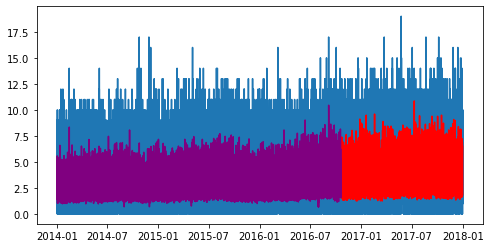

In [101]:
#fig, ax = plt.subplots(figsize=(8,4))
#ax.plot(patients_df['timestamp'], patients_df['patients'])
#ax.plot(patients_test['timestamp'], linpred, 'r')
#ax.plot(patients_train['timestamp'], linfit, 'purple')
#ax.plot()

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(patients_df['timestamp'], patients_df['patients'])
ax.plot(patients_test['timestamp'], psf_test2["mean"], 'r')
ax.plot(patients_train['timestamp'], psf_fit2["mean"], 'purple')
ax.plot()

[]

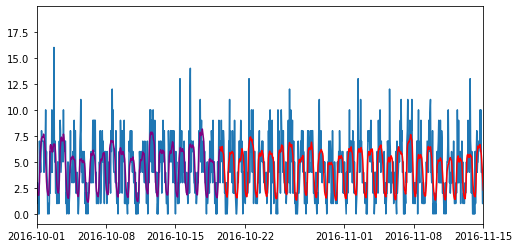

In [102]:
#fig, ax = plt.subplots(figsize=(8,4))
#ax.plot(patients_df['timestamp'], patients_df['patients'])
#ax.plot(patients_test['timestamp'], linpred, 'r')
#ax.plot(patients_train['timestamp'], linfit, 'purple')
#ax.set_xlim([datetime.date(2016, 10, 1), datetime.date(2016, 11, 15)])
#ax.plot()

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(patients_df['timestamp'], patients_df['patients'])
ax.plot(patients_test['timestamp'], psf_test2["mean"], 'r')
ax.plot(patients_train['timestamp'], psf_fit2["mean"], 'purple')
ax.set_xlim([datetime.date(2016, 10, 1), datetime.date(2016, 11, 15)])
ax.plot()

### Examining errors

In [103]:
y_true = patients_df.iloc[12:24540,1] 
y_pred = psf_fit2["mean"]
trend_season_mse_training = mean_squared_error(y_true, y_pred)
trend_season_mse_training

3.8081104831534622

In [104]:
trend_season_rmse_training = math.sqrt(mean_squared_error(y_true, y_pred))
trend_season_rmse_training

1.9514380551668715

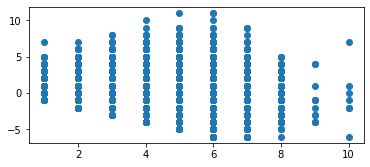

In [105]:
residual = y_true - round(y_pred)
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(round(y_pred), residual)

In [106]:
y_true = patients_df.iloc[24540:35052,1]
y_pred = psf_test2["mean"]
trend_season_mse_test = mean_squared_error(y_true, y_pred)
trend_season_mse_test

4.520253474046552

In [107]:
trend_season_rmse_test = math.sqrt(mean_squared_error(y_true, y_pred))
trend_season_rmse_test

2.126088773792513

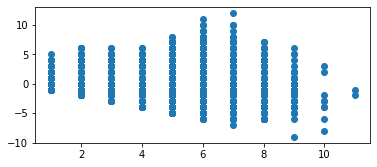

In [108]:
residual = y_true - round(y_pred)
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(round(y_pred), residual)

### Summary of Results

In [109]:
print('Trend Only:')
print('MSE for training:', trend_only_mse_training)
print('RMSE for training:', trend_only_rmse_training)
print('MSE for test:', trend_only_mse_test)
print('RMSE for test:', trend_only_rmse_test)
print('---------------------------------------------------')
print('Trend and Season:')
print('MSE for training:', trend_season_mse_training)
print('RMSE for training:', trend_season_rmse_training)
print('MSE for test:', trend_season_mse_test)
print('RMSE for test:', trend_season_rmse_test)

Trend Only:
MSE for training: 6.338465369127855
RMSE for training: 2.5176309040699065
MSE for test: 8.382552645444864
RMSE for test: 2.895263830023935
---------------------------------------------------
Trend and Season:
MSE for training: 3.8081104831534622
RMSE for training: 1.9514380551668715
MSE for test: 4.520253474046552
RMSE for test: 2.126088773792513
